# <a id='toc1_'></a>[LEGO Parts Classification using TensorFlow](#toc0_)
In this notebook, we will build and train a custom model and VGG16 to classify LEGO parts based on their images. The dataset used for this task is sourced from Kaggle's "B200C LEGO Classification Dataset".

**Table of contents**<a id='toc0_'></a>    
- [LEGO Parts Classification using TensorFlow](#toc1_)    
  - [Dataset Source](#toc1_1_)    
  - [Importing Libraries and Loading Data](#toc1_2_)    
  - [Custom Model Architecture](#toc1_3_)    
  - [Preparing Datasets](#toc1_4_)    
  - [Model Training and Evaluation](#toc1_5_)    
  - [Classification Report and Confusion Matrix](#toc1_6_)    
  - [Model Comparison](#toc1_7_)    
  - [Saving Class Information](#toc1_8_)    
  - [Classifying Custom Images](#toc1_9_)    
  - [LEGO classificator app](#toc1_10_)    
  - [Conclusion and Results](#toc1_11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Dataset Source](#toc0_)
The dataset used in this project can be found on Kaggle:
[B200C LEGO Classification Dataset](https://www.kaggle.com/datasets/ronanpickell/b200c-lego-classification-dataset)

The dataset consists of various LEGO part images, each belonging to one of the selected classes:
<br>```['3700', '32607', '2420', '6536', '3032', '2450', '99207']```</br>

## <a id='toc1_2_'></a>[Importing Libraries and Loading Data](#toc0_)
Let's start by importing the necessary libraries and loading the LEGO parts dataset. We will define the list of available classes (part numbers) and specify the path to the data folder.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Define the path to the data folder
data_folder = "./lego_parts"

# Define the list of available classes (part numbers)
classes = os.listdir(data_folder)
classes.remove('.DS_Store')

## <a id='toc1_3_'></a>[Custom Model Architecture](#toc0_)
We will define a custom model architecture using TensorFlow's Sequential API. This model will be used for the classification task.

In [2]:
our_model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(64, 64, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(len(classes), activation='softmax')
])

## <a id='toc1_4_'></a>[Preparing Datasets](#toc0_)
Next, we will create image datasets using TensorFlow's image_dataset_from_directory and split them into training, validation, and test datasets. These datasets will be used for training and evaluating our models.

In [3]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  data_folder,
  labels="inferred",
  label_mode="int",
  class_names=classes,
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=(64, 64),
  batch_size=32)

train_ds, test_ds = tf.keras.utils.split_dataset(train_ds, left_size=None, right_size=.15)

Found 28000 files belonging to 7 classes.
Using 22400 files for training.
Using 5600 files for validation.


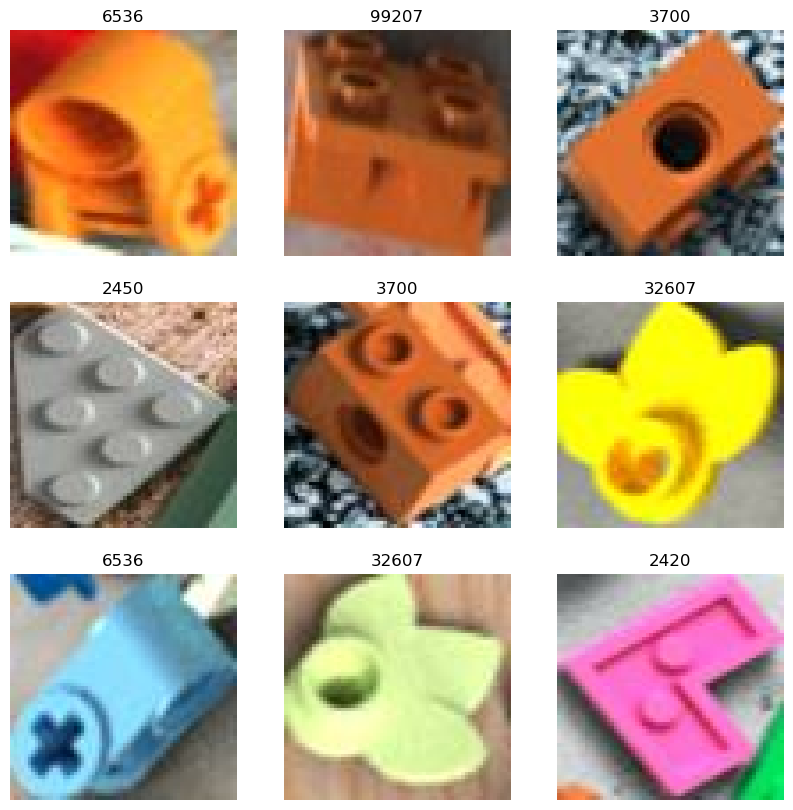

In [4]:
# Plot the first 9 images in the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")
plt.show()

## <a id='toc1_5_'></a>[Model Training and Evaluation](#toc0_)
We will define functions to augment the dataset, train and evaluate the model, and save the training history on each batch. This will help us monitor the progress of the models during training.

In [5]:
'''
# Function to augment the dataset
def augment_dataset(images, labels, aug_prob=0.5):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        augmented_images.append(img)
        augmented_labels.append(label)

        # Augmentation by horizontal flip (with probability aug_prob)
        if np.random.rand() < aug_prob:
            flipped_img = cv2.flip(img, 1)  # 1 - horizontal flip
            augmented_images.append(flipped_img)
            augmented_labels.append(label)

        # Augmentation by rotation (with probability aug_prob)
        if np.random.rand() < aug_prob:
            angle = np.random.randint(-15, 15)  # Random rotation angle within -15 to 15 degrees
            rotated_img = rotate_image(img, angle)
            augmented_images.append(rotated_img)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

def rotate_image(image, angle):
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    return cv2.warpAffine(image, M, (cols, rows))

train_images_list, train_labels_list = [], []
for images, labels in train_ds:
    train_images_list.extend(images.numpy())
    train_labels_list.extend(labels.numpy())

train_images, train_labels = np.array(train_images_list), np.array(train_labels_list)

test_images_list, test_labels_list = [], []
for images, labels in test_ds:
    test_images_list.extend(images.numpy())
    test_labels_list.extend(labels.numpy())

test_images, test_labels = np.array(test_images_list), np.array(test_labels_list)

augmented_images, augmented_labels = augment_dataset(train_images, train_labels)

augmented_train_ds = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
'''

'\n# Function to augment the dataset\ndef augment_dataset(images, labels, aug_prob=0.5):\n    augmented_images = []\n    augmented_labels = []\n    for img, label in zip(images, labels):\n        augmented_images.append(img)\n        augmented_labels.append(label)\n\n        # Augmentation by horizontal flip (with probability aug_prob)\n        if np.random.rand() < aug_prob:\n            flipped_img = cv2.flip(img, 1)  # 1 - horizontal flip\n            augmented_images.append(flipped_img)\n            augmented_labels.append(label)\n\n        # Augmentation by rotation (with probability aug_prob)\n        if np.random.rand() < aug_prob:\n            angle = np.random.randint(-15, 15)  # Random rotation angle within -15 to 15 degrees\n            rotated_img = rotate_image(img, angle)\n            augmented_images.append(rotated_img)\n            augmented_labels.append(label)\n\n    return np.array(augmented_images), np.array(augmented_labels)\n\ndef rotate_image(image, angle):\n    

In [6]:
# Custom callback to save training history on each batch
class BatchHistorySaverCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.batch_history = []

    def on_batch_end(self, batch, logs=None):
        batch_logs = logs.copy()
        batch_logs['batch'] = batch
        self.batch_history.append(batch_logs)

# Define train and evaluate functions with saving
def train_and_evaluate_model(model_name, model):
    print(f"Training and evaluating {model_name}...")
    model = tf.keras.models.clone_model(model)
    model.compile(optimizer=adam,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    checkpoint_path = f"./best/best_model_{model_name}.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    batch_history_saver = BatchHistorySaverCallback()

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping, checkpoint_callback, batch_history_saver]
    )

    eval_results = model.evaluate(test_ds)

    trained_models[model_name] = {
        "model": model,
        "train_accuracy": history.history['accuracy'][-1],
        "val_accuracy": history.history['val_accuracy'][-1],
        "test_accuracy": eval_results[1],
        "train_loss": history.history['loss'][-1],
        "val_loss": history.history['val_loss'][-1],
        "test_loss": eval_results[0],
        "history": history.history,  # Save the training history
        "batch_history": batch_history_saver.batch_history  # Save the batch history
    }

    model.save(f"./models/trained_model_{model_name}.h5")

In [7]:
# Define the number of epochs and the Adam optimizer
epochs = 100
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Define the models list
models = [
    ("our_model", our_model),
    ("vgg16", tf.keras.applications.VGG16(weights=None, input_shape=(64, 64, 3), classes=len(classes)))
]

# Define trained_models dictionary
trained_models = {}

In [8]:
# Run the training and evaluation loop for each model and optimizer
for model_name, model in models:
    train_and_evaluate_model(model_name, model)

Training and evaluating our_model...
Epoch 1/100
595/595 [==============================] - ETA: 0s - loss: 1.8097 - accuracy: 0.2564
Epoch 1: val_accuracy improved from -inf to 0.52893, saving model to ./best/best_model_our_model.h5
595/595 [==============================] - 12s 19ms/step - loss: 1.8097 - accuracy: 0.2564 - val_loss: 1.4868 - val_accuracy: 0.5289
Epoch 2/100
  6/595 [..............................] - ETA: 13s - loss: 1.5648 - accuracy: 0.3958

/Users/jakubsutowski/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


595/595 [==============================] - ETA: 0s - loss: 1.3081 - accuracy: 0.5050
Epoch 2: val_accuracy improved from 0.52893 to 0.60268, saving model to ./best/best_model_our_model.h5
595/595 [==============================] - 11s 19ms/step - loss: 1.3081 - accuracy: 0.5050 - val_loss: 1.2026 - val_accuracy: 0.6027
Epoch 3/100
594/595 [============================>.] - ETA: 0s - loss: 1.1064 - accuracy: 0.5920
Epoch 3: val_accuracy improved from 0.60268 to 0.61946, saving model to ./best/best_model_our_model.h5
595/595 [==============================] - 11s 19ms/step - loss: 1.1061 - accuracy: 0.5921 - val_loss: 1.0976 - val_accuracy: 0.6195
Epoch 4/100
594/595 [============================>.] - ETA: 0s - loss: 0.9948 - accuracy: 0.6348
Epoch 4: val_accuracy improved from 0.61946 to 0.63893, saving model to ./best/best_model_our_model.h5
595/595 [==============================] - 11s 18ms/step - loss: 0.9945 - accuracy: 0.6349 - val_loss: 1.0299 - val_accuracy: 0.6389
Epoch 5/100
5

Epoch 1/100
  6/595 [..............................] - ETA: 1:15 - loss: 2.4437 - accuracy: 0.1875WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0401s vs `on_train_batch_end` time: 0.0749s). Check your callbacks.


595/595 [==============================] - ETA: 0s - loss: 1.7792 - accuracy: 0.2352
Epoch 1: val_accuracy improved from -inf to 0.44571, saving model to ./best/best_model_vgg16.h5
595/595 [==============================] - 82s 137ms/step - loss: 1.7792 - accuracy: 0.2352 - val_loss: 1.3960 - val_accuracy: 0.4457
Epoch 2/100
595/595 [==============================] - ETA: 0s - loss: 0.9940 - accuracy: 0.6235
Epoch 2: val_accuracy improved from 0.44571 to 0.72357, saving model to ./best/best_model_vgg16.h5
595/595 [==============================] - 97s 164ms/step - loss: 0.9940 - accuracy: 0.6235 - val_loss: 0.7545 - val_accuracy: 0.7236
Epoch 3/100
595/595 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.7921
Epoch 3: val_accuracy improved from 0.72357 to 0.84304, saving model to ./best/best_model_vgg16.h5
595/595 [==============================] - 141s 237ms/step - loss: 0.5890 - accuracy: 0.7921 - val_loss: 0.4891 - val_accuracy: 0.8430
Epoch 4/100
595/595 [===

In [9]:
# Save results to a CSV file
results_df = pd.DataFrame.from_dict(trained_models, orient='index')
results_df.to_csv("./csv/trained_models_results.csv")

## <a id='toc1_6_'></a>[Classification Report and Confusion Matrix](#toc0_)
We will load the best model and our model and evaluate them on the test dataset. We'll generate a classification report and a confusion matrix to assess the models' performance and accuracy.

In [10]:
# Load the best model and our model
best_model = tf.keras.models.load_model('./best/best_model_VGG16.h5')
our_model = tf.keras.models.load_model('./best/best_model_our_model.h5')


Evaluating vgg16...
105/105 [==============================] - 3s 28ms/step

Classification Report: Train
              precision    recall  f1-score   support

        3700       0.96      0.93      0.94       476
       32607       0.94      0.90      0.92       484
        2420       0.93      0.92      0.93       485
        6536       0.87      0.91      0.89       468
        3032       0.99      0.98      0.99       499
        2450       0.93      0.97      0.95       476
       99207       0.88      0.89      0.89       472

    accuracy                           0.93      3360
   macro avg       0.93      0.93      0.93      3360
weighted avg       0.93      0.93      0.93      3360

105/105 [==============================] - 3s 28ms/step

Classification Report: Validation
              precision    recall  f1-score   support

        3700       0.96      0.93      0.94       476
       32607       0.94      0.90      0.92       484
        2420       0.93      0.92      0.9

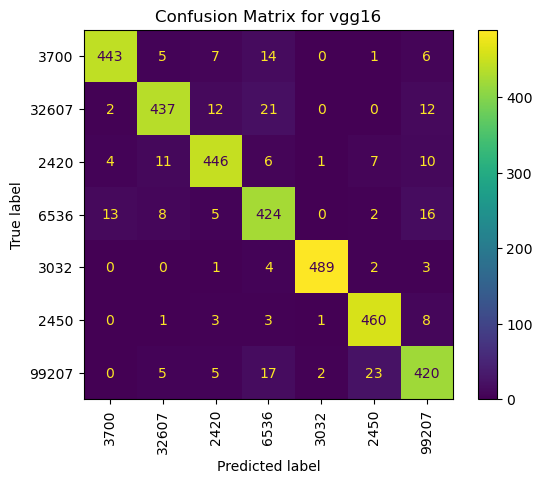

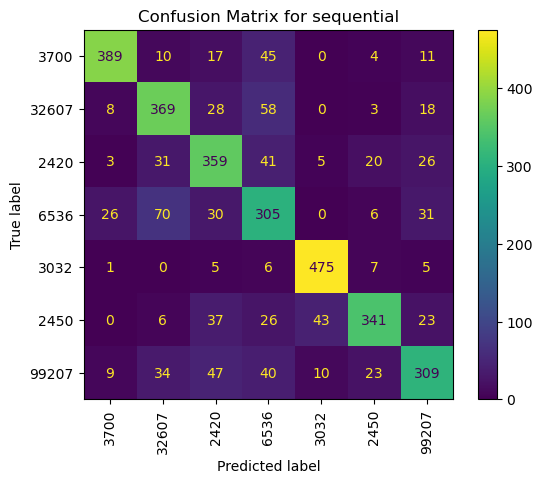

In [21]:
# Evaluate the models and generate classification reports
for m in [best_model, our_model]:
    print(f"\nEvaluating {m.name}...")
    for s in [train_ds, val_ds, test_ds]:
        true_labels = np.concatenate([y for x, y in test_ds], axis=0)
        predictions = m.predict(test_ds)
        predicted_labels = np.argmax(predictions, axis=1)
        class_names = classes
        report = classification_report(true_labels, predicted_labels, target_names=class_names)
        print(f"\nClassification Report: {'Train' if s == train_ds else 'Validation' if s == val_ds else 'Test'}")
        print(report)

    # Generate confusion matrix for the best model
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(xticks_rotation="vertical")
    plt.title(f"Confusion Matrix for {m.name}")
    plt.grid(False)

## <a id='toc1_7_'></a>[Model Comparison](#toc0_)
In this section, we will compare the performance of different models and optimizers by plotting accuracy and loss. We will visualize the trends and make informed decisions about selecting the best model.

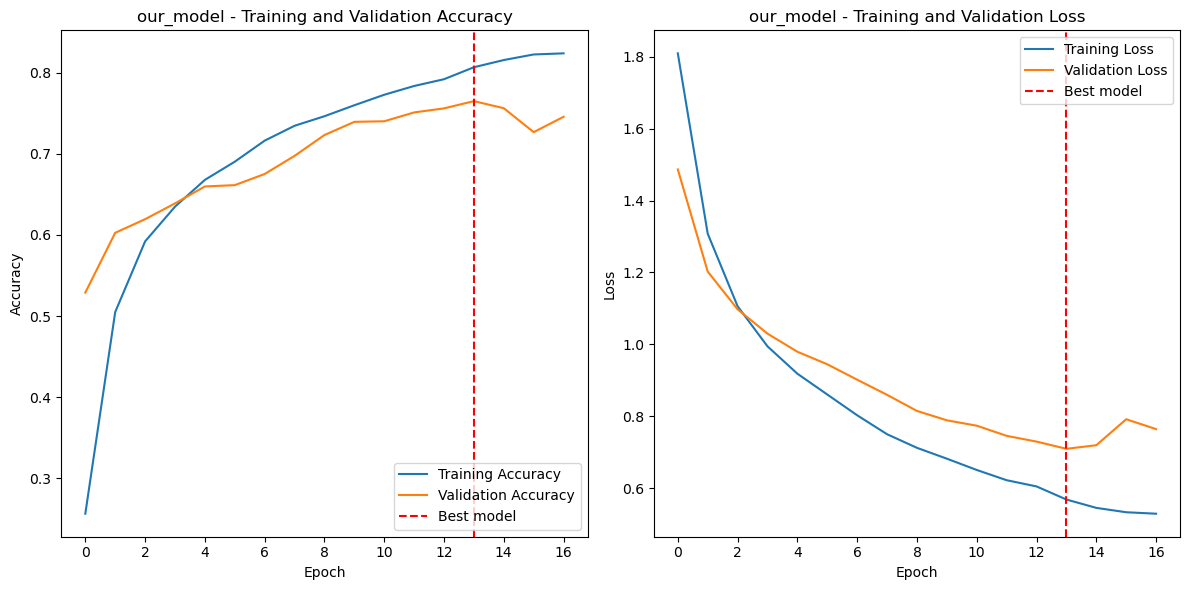

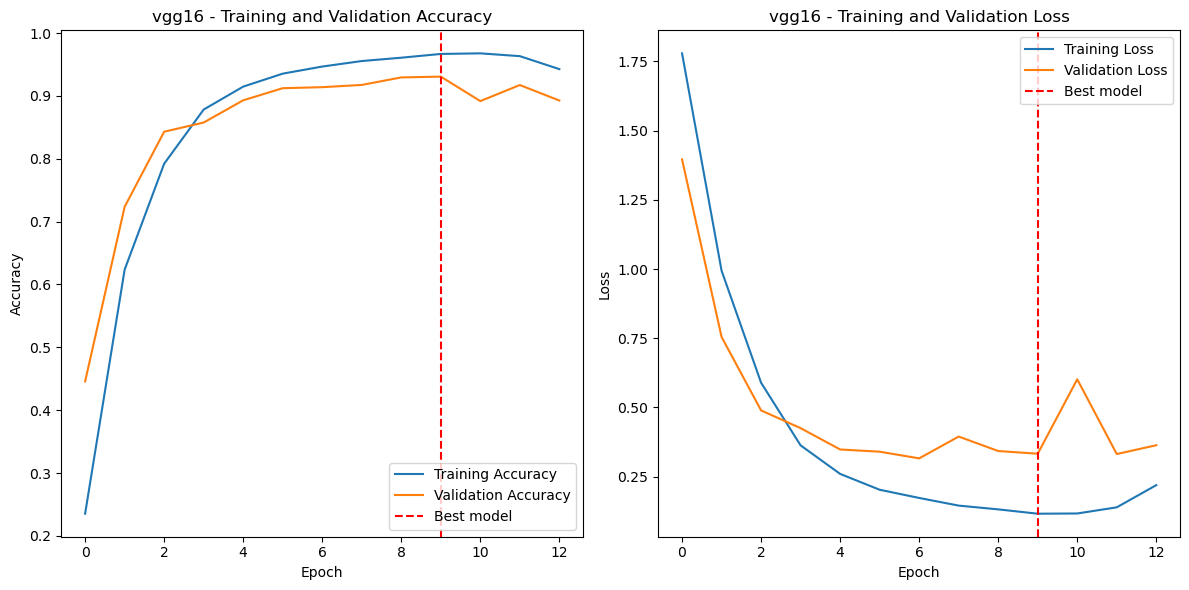

In [12]:
# Generate accuracy and loss plots for each model
for model_name in trained_models:
    history = trained_models[model_name]['history']
    epochs_range = range(len(history['accuracy']))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy')
    plt.axvline(x=len(history['accuracy']) - 4, color='r', linestyle='--', label='Best model')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['loss'], label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.axvline(x=len(history['accuracy']) - 4, color='r', linestyle='--', label='Best model')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

In [13]:
# Load DataFrame with results
results_df = pd.read_csv("./csv/trained_models_results.csv", index_col=0, usecols=[0, 2, 3, 4, 5, 6, 7])
results_df

,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,test_loss
our_model,0.823897,0.745714,0.758036,0.528896,0.764272,0.703551
vgg16,0.942647,0.892679,0.928274,0.219069,0.363211,0.357889


In [14]:
# Sort the DataFrame by test accuracy
results_df.sort_values(by=['test_accuracy'], ascending=False, inplace=True)

# Create a list of model names
models_list = results_df.index.tolist()

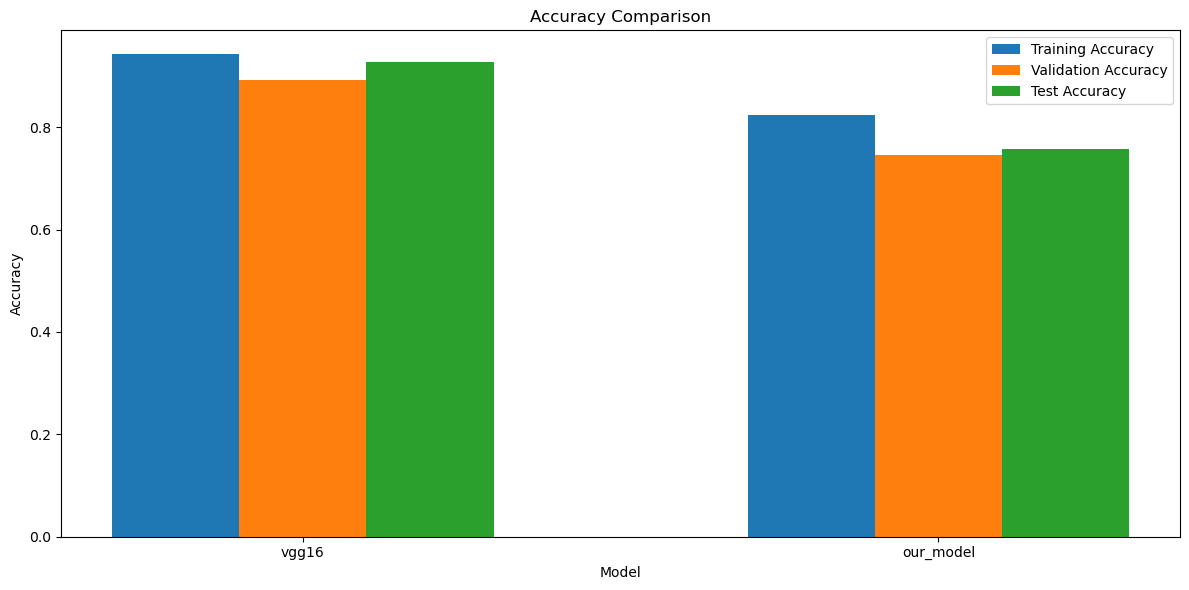

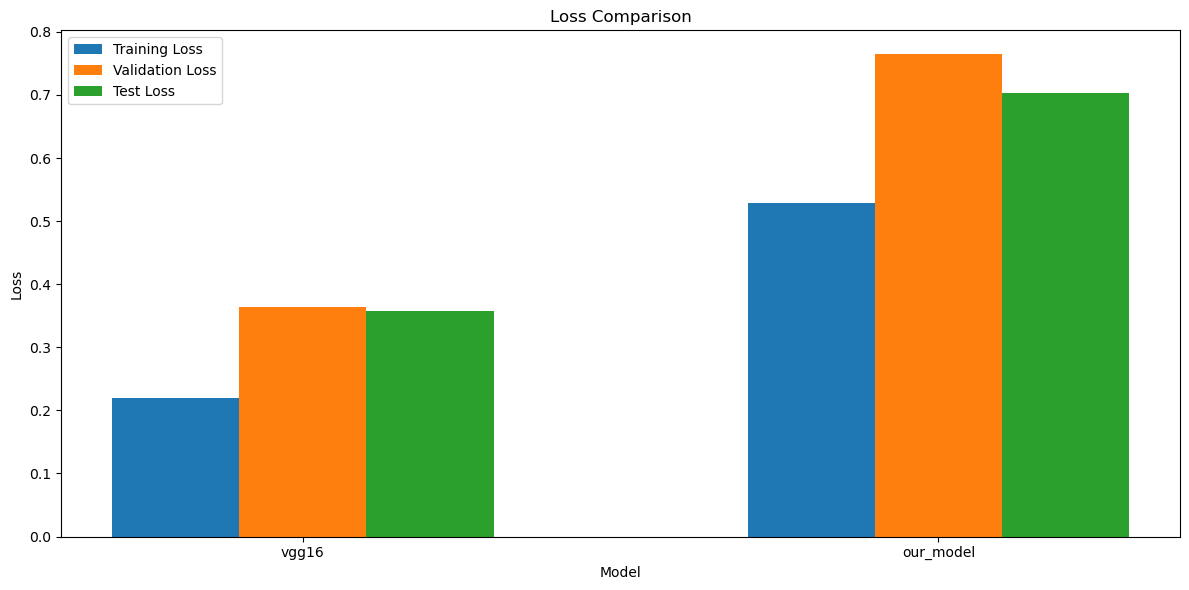

In [15]:
# Compare the accuracy of the models
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(models_list))

plt.bar(index, results_df['train_accuracy'], bar_width, label='Training Accuracy')
plt.bar(index + bar_width, results_df['val_accuracy'], bar_width, label='Validation Accuracy')
plt.bar(index + 2 * bar_width, results_df['test_accuracy'], bar_width, label='Test Accuracy')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks(index + bar_width, models_list)
plt.legend()
plt.tight_layout()
plt.show()

# Compare the loss of the models
plt.figure(figsize=(12, 6))

plt.bar(index, results_df['train_loss'], bar_width, label='Training Loss')
plt.bar(index + bar_width, results_df['val_loss'], bar_width, label='Validation Loss')
plt.bar(index + 2 * bar_width, results_df['test_loss'], bar_width, label='Test Loss')

plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.xticks(index + bar_width, models_list)
plt.legend()
plt.tight_layout()
plt.show()

## <a id='toc1_8_'></a>[Saving Class Information](#toc0_)
To ensure we can map the model predictions back to the actual class names, we will save information about the classes and their corresponding indices. We'll use pickle to save the classes list and write the class mapping to a CSV file.

In [16]:
# Save the classes list to a separate file using pickle
classes_file = "./classes.pkl"
with open(classes_file, 'wb') as file:
    pickle.dump(classes, file)

# Write the class mapping to a CSV file
csv_file = "./class_mapping.csv"
with open(csv_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Index', 'Class'])
    for index, class_name in enumerate(classes):
        csv_writer.writerow([index, class_name])

## <a id='toc1_9_'></a>[Classifying Custom Images](#toc0_)
Finally, we can use the best model and our model to classify custom images of LEGO parts. We'll demonstrate how to preprocess and classify these images.

In [17]:
def load_class_labels_from_csv(csv_file):
    class_labels = {}
    with open(csv_file, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        for row in reader:
            class_index = int(row[0])
            class_name = row[1].strip()

            if isinstance(class_name, list):
                class_name = ''.join(class_name)

            class_labels[class_index] = class_name

    return class_labels

def preprocess_custom_input(img_path):
    img = image.load_img(img_path, target_size=(64, 64)) 
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_batch

    return img_preprocessed

def classify_with_custom_model(img_path, model, class_labels_file):
    class_labels = load_class_labels_from_csv(class_labels_file)

    img_preprocessed = preprocess_custom_input(img_path)

    prediction = model.predict(img_preprocessed)

    class_index = np.argmax(prediction[0])
    probability = prediction[0][class_index]

    class_name = class_labels[class_index]

    return f"{class_name} - {probability:.2f}"

In [18]:
img_path = "./lego_parts/3700/0.jpg"
print('Best model prediction: {}\n'.format(classify_with_custom_model(img_path, best_model, 'class_mapping.csv')))
print('Our model prediction: {}'.format(classify_with_custom_model(img_path, our_model, 'class_mapping.csv')))

1/1 [==============================] - 0s 125ms/step
Best model prediction: 3700 - 1.00

1/1 [==============================] - 0s 51ms/step
Our model prediction: 3700 - 0.98


## <a id='toc1_10_'></a>[LEGO classificator app](#toc0_)
The lego_classificator.py script is a command-line application used for LEGO parts classification. It takes two arguments as inputs:

--model_path: The path to the pre-trained model (default is set to "./best/best_model_VGG16.h5")

--img_path: The path to the image file for classification

The script loads the specified pre-trained model, preprocesses the input image, and then makes predictions on the image using the model. The top predictions with their corresponding class names and probabilities are displayed in a pandas DataFrame. Additionally, the predictions are saved to a CSV file in the "prediction" directory, with the same name as the input image and ".csv" extension.

In [19]:
%%writefile lego_classificator.py
import argparse
import pickle
import csv
from tensorflow import keras
import numpy as np
import pandas as pd
import os

parser = argparse.ArgumentParser(description="LEGO classifier")
parser.add_argument('--model_path', type=str, default="./best/best_model_VGG16.h5")
parser.add_argument('--img_path', type=str)

args = parser.parse_args()

# Load the classes list from the pickle file
classes_file = "./classes.pkl"
with open(classes_file, 'rb') as file:
    classes = pickle.load(file)

# Load the class mapping from the CSV file
csv_file = "./class_mapping.csv"
class_mapping = {}
with open(csv_file, 'r', newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        index, class_name = row
        class_mapping[int(index)] = class_name

model = keras.models.load_model(args.model_path)
img = keras.preprocessing.image.load_img(args.img_path, target_size=model.input_shape[1:3])
array = keras.preprocessing.image.img_to_array(img)
array = np.expand_dims(array, 0)

y_pred = model.predict(array)

# Get the predicted class index (assuming it's a one-hot encoded prediction)
predicted_class_index = np.argmax(y_pred[0])

# Get the predicted class name from the class mapping
predicted_class_name = class_mapping[predicted_class_index]

# Get the probability of the predicted class
predicted_probability = y_pred[0][predicted_class_index]

result_df = pd.DataFrame([{'id': predicted_class_index, 'name': predicted_class_name, 'probability': predicted_probability}])

# Create the 'predictions' folder if it doesn't exist
if not os.path.exists('./predictions'):
    os.makedirs('./predictions')

# Generate the CSV name with the number from the img_path
filename = os.path.basename(args.img_path)  # Get the filename from the img_path
csv_name = f'./predictions/pred({filename}).csv'  # e.g., './predictions/pred(44).csv'

# Save the result to a CSV file
result_df.to_csv(csv_name, index=False)

print(result_df)

Writing lego_classificator.py


To classify a LEGO part image using the pre-trained VGG16 model, run the following command in the terminal.

In [20]:
!python lego_classificator.py --model_path ./best/best_model_VGG16.h5 --img_path ./lego_parts/3700/44.jpg

1/1 [==============================] - 0s 132ms/step
   id  name  probability
0   0  3700     0.998521


## <a id='toc1_11_'></a>[Conclusion and Results](#toc0_)
Overall, we successfully built and trained a custom model and VGG16 for LEGO parts classification. The models were evaluated and compared based on their performance on the test dataset. The classification reports and confusion matrices provide insights into the model's ability to correctly classify different LEGO parts. The comparison plots allow us to visualize the accuracy and loss trends for different models and optimizers.

Based on the results, we can make informed decisions about selecting the best model for the LEGO parts classification task.